In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

from datetime import datetime

warnings.filterwarnings("ignore")
sns.set_style()
plt.rcParams["figure.figsize"] = (12, 6)

In [10]:
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC

from sklearn.metrics import classification_report, roc_auc_score, make_scorer, recall_score

In [98]:
modelos = [
    {
        "nombre": "Naive Bayes",
        "modelo": MultinomialNB(),
        "param_grid": {
            "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
            "fit_prior": [True, False],
        },
    },
    {
        "nombre": "Arbol Clasificacion",
        "modelo": DecisionTreeClassifier(),
        "param_grid": {
            "max_depth": [3, 4, 5, 6, 7, 8, 9, 10],
            "max_leaf_nodes": [10, 50, 100],
            "criterion": ["gini", "entropy"],
        },
    },
    {
        "nombre": "Random Forest",
        "modelo": RandomForestClassifier(),
        "param_grid": {
            "max_depth": [5, 6, 7, 8, 9, 10],
            "n_estimators": [500, 600, 700, 800, 900, 1000],
        },
    },
    {
        "nombre": "Gradient Bossting",
        "modelo": GradientBoostingClassifier(),
        "param_grid": {
            "max_depth": [5, 6, 7, 8, 9, 10],
            "learning_rate": [0.001, 0.01, 0.1, 1],
        },
    },
    {
        "nombre": "SVM",
        "modelo": SVC(),
        "param_grid": {"C": [0.1, 1, 10, 100], "kernel": ["linear", "poly"], "degree": [2, 3, 4]},
    },
]

In [117]:
def entrenar_ensamble_de_modelos_gridcv(
    grilla_gridcv_con_modelos, X_train, X_test, y_train, y_test
):
    for model_info in grilla_gridcv_con_modelos:
        print("Training", model_info["nombre"], "...")
        model = model_info["modelo"]
        param_grid = model_info["param_grid"]

        grid_search = GridSearchCV(model, param_grid, cv=5)
        grid_search.fit(X_train, y_train)

        obtener_desempeno_modelo_en_grilla(grid_search, X_test, y_test)

def resumir_resultados_grid_cv(diccionario_resultados):
    df_resultados = pd.DataFrame(diccionario_resultados)
    df_resultados["params_str"] = df_resultados["params"].astype(str)

    return df_resultados


def graficar_resultados_grid_cv(resultado_df):
    sns.lineplot(data=resultado_df, x="params_str", y="mean_test_score", marker="o")
    plt.tick_params(axis="x", labelrotation=90)


def analizar_resultados_grid_cv(diccionario_resultados):
    df_resultados = resumir_resultados_grid_cv(diccionario_resultados)
    graficar_resultados_grid_cv(df_resultados)

    return df_resultados


def obtener_desempeno_modelo_en_grilla(modelo_grilla, X_test, y_test):
    print("--------------Resultados Conjunto de Entrenamiento-----------------")
    print("Los resultados en la busqueda de hiperparametros son:")
    resultados_grilla = analizar_resultados_grid_cv(modelo_grilla.cv_results_)
    plt.show()
    print(f"Los mejores parametros fueron: {modelo_grilla.best_params_}")
    print(f"El mejor desempeno fue: {modelo_grilla.best_score_}")

    print("\n\n--------------Resultados Conjunto de Validacion-----------------")
    yhat = modelo_grilla.predict(X_test)
    print("Los resultados en el conjunto de validacion son:")
    print(classification_report(y_test, yhat))

    print("---------------------------------------------------------------------")

    return resultados_grilla

In [100]:
df = pd.read_csv("RegistroTumores_FALP.csv")

In [149]:
def preprocesar_dataset_cancer_mama(df):
    tmp = df.copy()
    
    # Elimina columnas redundantes o sin mayor informacion
    tmp = tmp.drop(columns=["CATEGORIA", "SUBCATEGORIA", "CODIGO_COMUNA", "ID_CASO"])

    # Binariza la edad
    tmp["RANGO_ETARIO"] = pd.cut(
        tmp["EDAD"],
        [-np.inf, 5, 11, 18, 26, 60, np.inf],
        labels=["Primera Infancia", "Infancia", "Adolescencia", "Juventud", "Adultez", "Vejez"],
    )
    tmp = tmp.drop(columns=["EDAD"])

    # Solamente deja las filas que tengan al menos 1 examen
    columnas_examenes = ["CT", "CN", "CM", "PT", "PN", "PM"]
    tmp = tmp.dropna(subset=columnas_examenes, how="all")

    # Elimina las fechas
    columnas_fechas = ["FECHA_DIAGNOSTICO", "FECHA_DEFUNCION", "FECHA_INICIO_TTO", "FECHA_FIN_TTO"]
    tmp = tmp.drop(columns=columnas_fechas)

    # Crea el vector objetivo
    reemplazar_estadio = {
        "0": 1,
        "I": 1,
        "II": 2,
        "III": 3,
        "IV": 3,
    }

    tmp["STATUS"] = tmp["ESTADIO"].replace(reemplazar_estadio)
    tmp = tmp.drop(columns=["ESTADIO"])

    # Rellena todas las cols que carezcan de datos
    tmp = tmp.fillna("SO")

    # Convierte todas las columnas a variables indicadores
    tmp = pd.get_dummies(tmp, drop_first=True)

    return tmp

In [153]:
# Deja solo el cancer de mama
mama = df.query("CATEGORIA == 'MAMA'")

# Deja solo los registros con estadio
mama_con_estadio = mama[~mama["ESTADIO"].isna()]

# Deja solo los registros sin estadio
mama_sin_estadio = mama[mama["ESTADIO"].isna()]

In [154]:
mama_preproc = preprocesar_dataset_cancer_mama(mama_con_estadio)
mama_sin_estadio_preproc = preprocesar_dataset_cancer_mama(mama_sin_estadio)

In [157]:
X = mama_preproc.drop(columns="STATUS")
y = mama_preproc["STATUS"]

In [162]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.333, random_state=1)

Training Naive Bayes ...
--------------Resultados Conjunto de Entrenamiento-----------------
Los resultados en la busqueda de hiperparametros son:


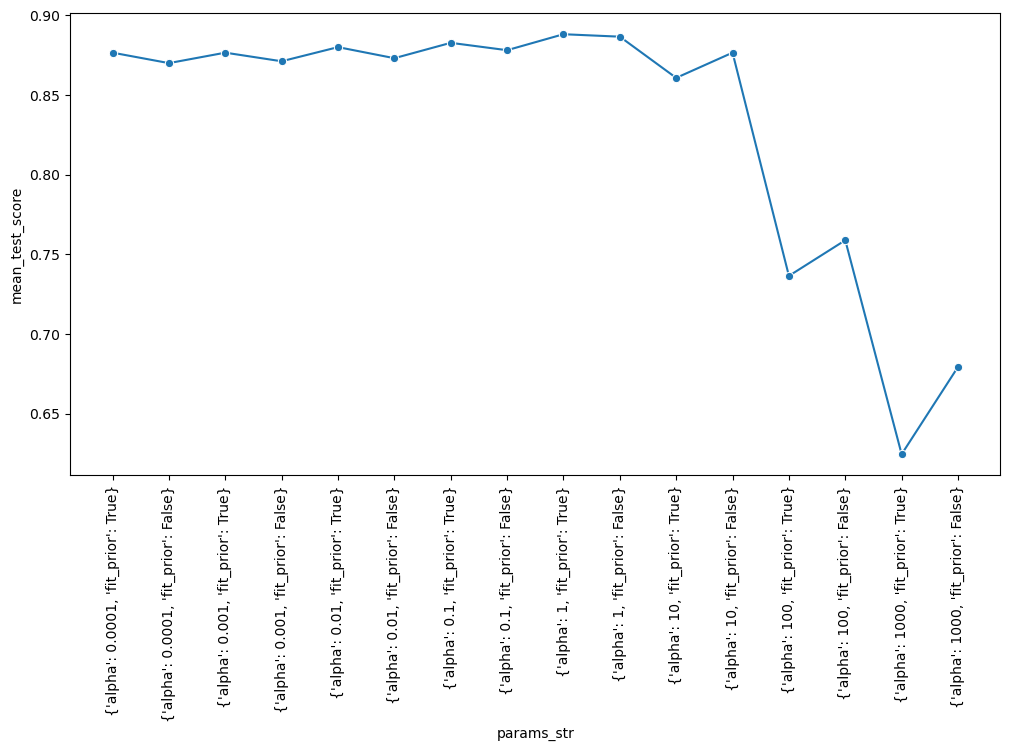

Los mejores parametros fueron: {'alpha': 1, 'fit_prior': True}
El mejor desempeno fue: 0.8880665967371171


--------------Resultados Conjunto de Validacion-----------------
Los resultados en el conjunto de validacion son:
              precision    recall  f1-score   support

           1       0.94      0.93      0.93       446
           2       0.82      0.86      0.84       488
           3       0.88      0.83      0.85       361

    accuracy                           0.88      1295
   macro avg       0.88      0.87      0.88      1295
weighted avg       0.88      0.88      0.88      1295

---------------------------------------------------------------------
Training Arbol Clasificacion ...
--------------Resultados Conjunto de Entrenamiento-----------------
Los resultados en la busqueda de hiperparametros son:


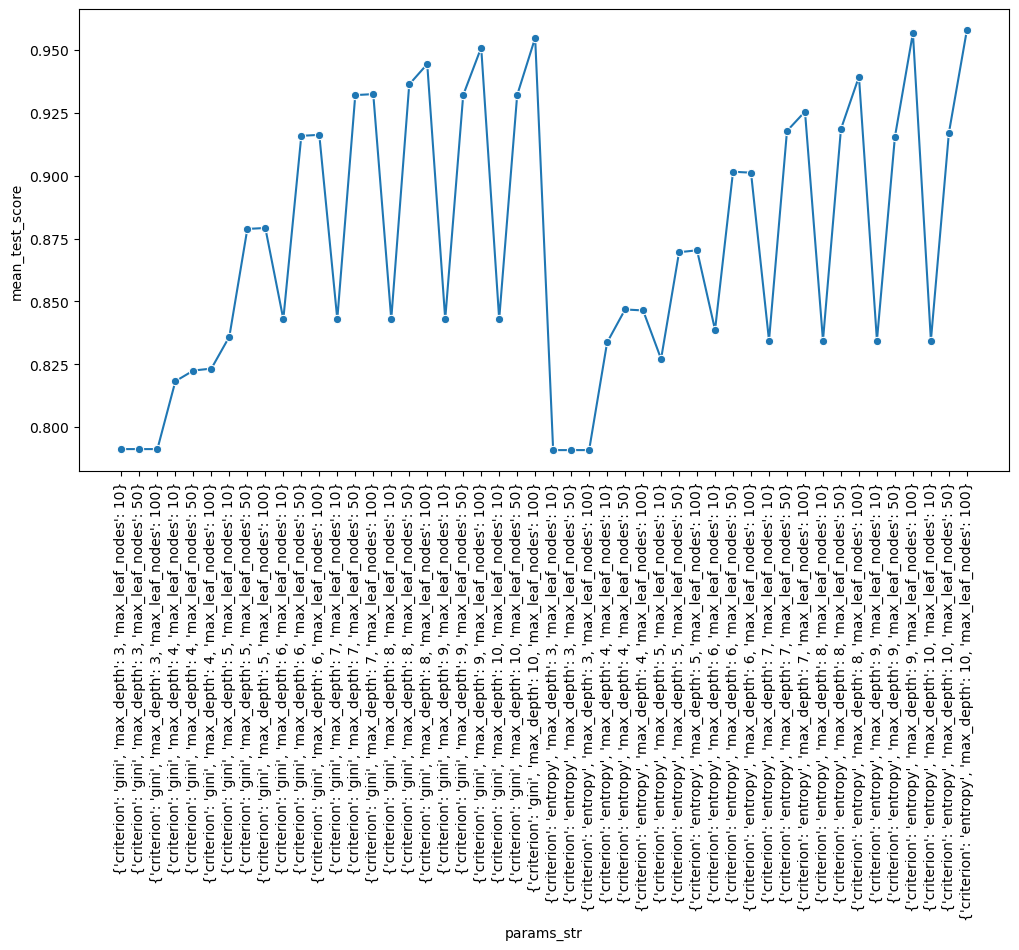

Los mejores parametros fueron: {'criterion': 'entropy', 'max_depth': 10, 'max_leaf_nodes': 100}
El mejor desempeno fue: 0.9579351440623117


--------------Resultados Conjunto de Validacion-----------------
Los resultados en el conjunto de validacion son:
              precision    recall  f1-score   support

           1       1.00      0.95      0.97       446
           2       0.93      1.00      0.96       488
           3       1.00      0.97      0.98       361

    accuracy                           0.97      1295
   macro avg       0.98      0.97      0.97      1295
weighted avg       0.97      0.97      0.97      1295

---------------------------------------------------------------------
Training Random Forest ...
--------------Resultados Conjunto de Entrenamiento-----------------
Los resultados en la busqueda de hiperparametros son:


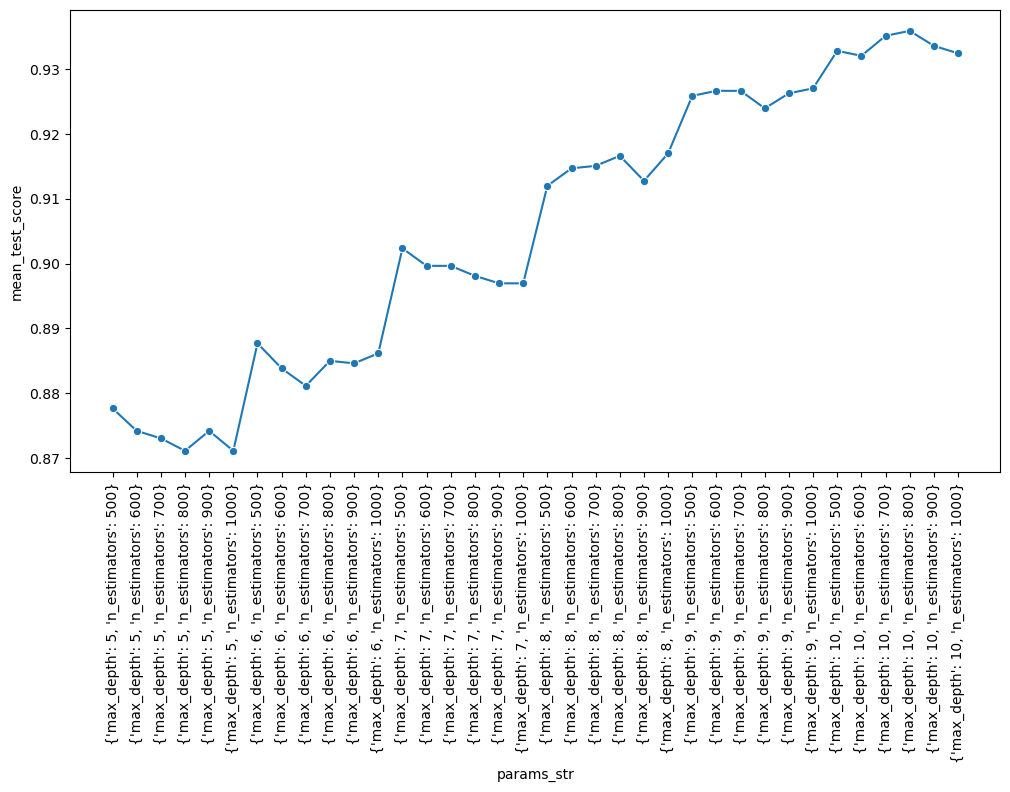

Los mejores parametros fueron: {'max_depth': 10, 'n_estimators': 800}
El mejor desempeno fue: 0.9359259341918301


--------------Resultados Conjunto de Validacion-----------------
Los resultados en el conjunto de validacion son:
              precision    recall  f1-score   support

           1       0.97      0.93      0.95       446
           2       0.89      0.97      0.93       488
           3       0.99      0.93      0.96       361

    accuracy                           0.94      1295
   macro avg       0.95      0.94      0.95      1295
weighted avg       0.95      0.94      0.94      1295

---------------------------------------------------------------------
Training Gradient Bossting ...
--------------Resultados Conjunto de Entrenamiento-----------------
Los resultados en la busqueda de hiperparametros son:


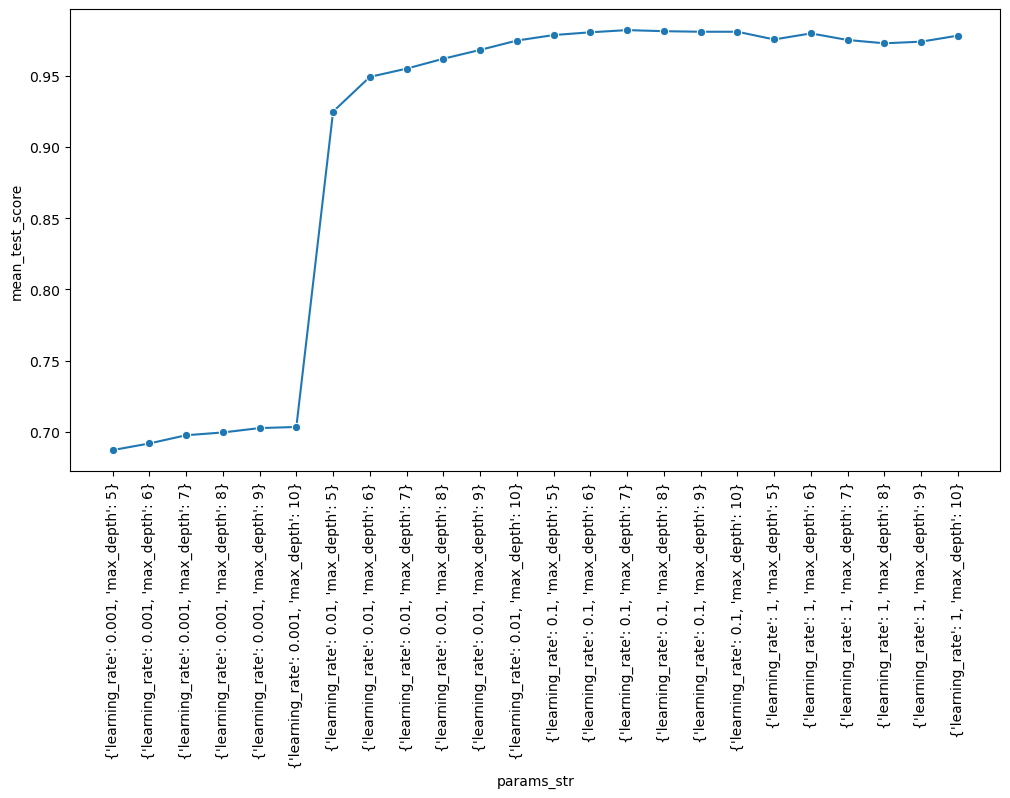

Los mejores parametros fueron: {'learning_rate': 0.1, 'max_depth': 7}
El mejor desempeno fue: 0.9818614650984593


--------------Resultados Conjunto de Validacion-----------------
Los resultados en el conjunto de validacion son:
              precision    recall  f1-score   support

           1       1.00      0.98      0.99       446
           2       0.98      1.00      0.99       488
           3       1.00      0.99      0.99       361

    accuracy                           0.99      1295
   macro avg       0.99      0.99      0.99      1295
weighted avg       0.99      0.99      0.99      1295

---------------------------------------------------------------------
Training SVM ...
--------------Resultados Conjunto de Entrenamiento-----------------
Los resultados en la busqueda de hiperparametros son:


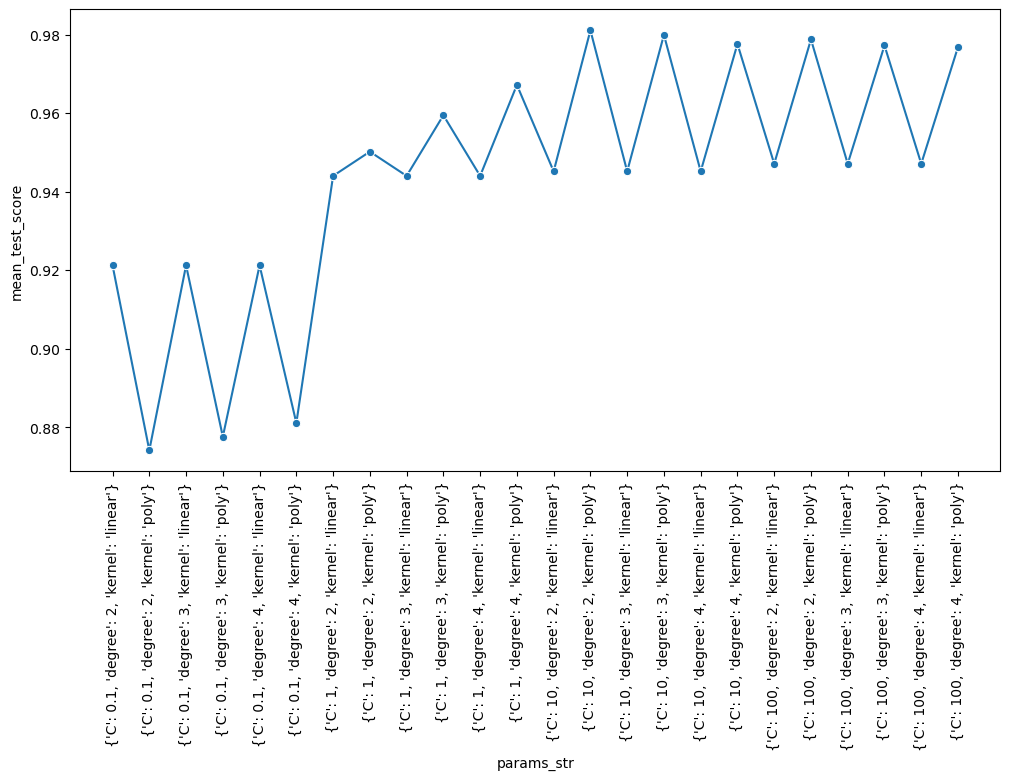

Los mejores parametros fueron: {'C': 10, 'degree': 2, 'kernel': 'poly'}
El mejor desempeno fue: 0.9810892643262585


--------------Resultados Conjunto de Validacion-----------------
Los resultados en el conjunto de validacion son:
              precision    recall  f1-score   support

           1       0.99      0.97      0.98       446
           2       0.97      0.99      0.98       488
           3       0.99      0.99      0.99       361

    accuracy                           0.98      1295
   macro avg       0.99      0.98      0.99      1295
weighted avg       0.98      0.98      0.98      1295

---------------------------------------------------------------------


In [163]:
entrenar_ensamble_de_modelos_gridcv(modelos, X_train, X_test, y_train, y_test)